## Predicting Outcomes of US Supreme Court Oral Arguments

Team: Fei Wang, Reza R Pratama, Shradha Ganapathy, Xiomara Salazar





### Description

The Supreme Court of the US (SCOTUS) is the highest court in the United States. It holds the power of judicial review – determining whether a statute violates the Constitution. The court consists of nine Justices (a chief justice and eight associate justices). Justices can serve for life (i.e., until they die, retire, resign, get impeached, etc.), so one Justice can influence decisions for many decades. Clearly, the decisions made by the SCOTUS have great public policy impact in the US. 

In general, the cases that the SCOTUS review have been given a decision by a lower court, and are brought to the Court for appeal of said decision. For these cases, the Court will take briefs and conduct an oral argument with the attorneys representing the (usually 2) parties in this case. Following the oral argument, each Justice gets one vote, and the majority vote determines the case outcome. Example SCOTUS case: https://www.oyez.org/cases/2018/17-204 

For this project, we are interested in predicting the outcome of the case (i.e., which party gets the majority vote) from the oral argument transcripts. These transcripts (see Dataset) are dialogs of English natural language text. This can be thought of as a text classification task, where the transcripts are the input documents. The labels we want to predict are the outcomes (e.g., Y/N the petitioner “wins”). 


### Dataset
Supreme Court Oral Arguments Corpus from [Convokit](https://convokit.cornell.edu/documentation/supreme.html). We analyzed data across eight years of the George W. Bush and two terms (8 years) of the Barack Obama administration (2001 - 2018). 

<h3> <i> Why did we select this subset of data? </i> </h3>

As justices in the US Supreme Court are political appointees -- confirmed to their positions via Senate -- we wanted to evaluate outcomes across two different political periods. We settled on choosing an administration under a Democratic President and another under a Republican President. 

Our initial idea was to evaluate courts across the Obama and the Trump administrations; however, the dataset does not cover the entire Trump administration. We, thus, decided to select the Bush and Obama administrations. Both these administrations had fairly balanced courts in terms of political / legal leanings. Additionally, both Presidents Bush and Obama appointed two justices each to the Supreme Court during their tenures - implying that the constitution of our courts remained fairly consistent with the same "number of changes." The choice of successive administrations was also important to reflect the fairly contiguous nature of the Supreme Court where Justices serve until retirement or passing. 

We decided to choose Presidents with two terms to see if there was a difference at play between how a court would vote between the first and second terms of a President - and more broadly speaking - whether the term had an impact at all.The long time span allowed for us to also compare - for some justices - whether their votes differed between their times under the Bush and subsequently the Obama administration.

Data downloaded and saved as csv using this script: download_data.py

## Data Exploration

#### Load Data

In [80]:
import pandas as pd
import statsmodels.formula.api as sm
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [81]:
path = 'http://rezarzky.my.id/dataset/' #change to your data location

In [82]:
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf='https://zissou.infosci.cornell.edu/convokit/datasets/supreme-corpus/cases.jsonl', lines=True)

## Cases

In [83]:
# filter out cases that 2011-2018 AND win_side [0,1]
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 7065 to 7686
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    601 non-null    object 
 1   year                  601 non-null    int64  
 2   citation              599 non-null    object 
 3   title                 601 non-null    object 
 4   petitioner            601 non-null    object 
 5   respondent            601 non-null    object 
 6   docket_no             601 non-null    object 
 7   court                 601 non-null    object 
 8   decided_date          601 non-null    object 
 9   url                   601 non-null    object 
 10  transcripts           601 non-null    object 
 11  adv_sides_inferred    601 non-null    bool   
 12  known_respondent_adv  601 non-null    bool   
 13  advocates             601 non-null    object 
 14  win_side              601 non-null    float64
 15  win_side_detail    

In [84]:
# Count number of cases per year
df_cases.groupby(['year']).size()

year
2011    78
2012    78
2013    75
2014    74
2015    80
2016    69
2017    73
2018    74
dtype: int64

In [85]:
# Check in what month the case usually decided
df_cases['decided_date'] = pd.to_datetime(df_cases['decided_date'])
df_cases['decided_month'] = df_cases['decided_date'].dt.month
df_cases['decided_year'] = df_cases['decided_date'].dt.year


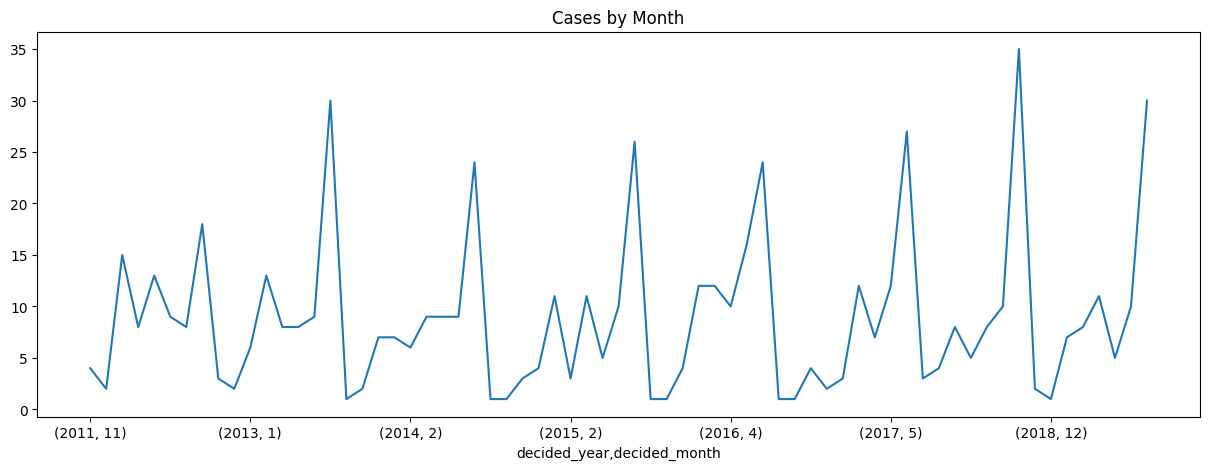

In [86]:
# Create Line Graph of Cases by Per Month
df_cases.groupby(['decided_year', 'decided_month']).size().plot(kind='line', figsize=(15, 5), title='Cases by Month')
plt.show()

### Conversation

In [87]:
# Check head
df_convos.head()

,id,vectors,meta.case_id,meta.advocates,meta.win_side,meta.votes_side,year
0,22149,[],2001_01-584,"{'john_crabtree': {'side': 1, 'role': 'on beha...",0.0,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",2001
1,22721,[],2001_00-730,"{'william_perry_pendley': {'side': 1, 'role': ...",0.0,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",2001
2,21448,[],2001_00-1214,"{'william_h_mills': {'side': 0, 'role': 'Argue...",0.0,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",2001
3,22788,[],2001_00-1293,"{'ann_e_beeson': {'side': 0, 'role': 'Argued t...",1.0,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",2001
4,21372,[],2001_00-795,"{'paul_d_clement': {'side': 1, 'role': 'Depart...",0.0,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",2001


In [88]:
# Check datatype
df_convos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1292 non-null   int64  
 1   vectors          1292 non-null   object 
 2   meta.case_id     1292 non-null   object 
 3   meta.advocates   1292 non-null   object 
 4   meta.win_side    1290 non-null   float64
 5   meta.votes_side  1290 non-null   object 
 6   year             1292 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 70.8+ KB


In [89]:
# Check for number of unique meta.win_side
df_convos['meta.win_side'].value_counts()

1.0    853
0.0    435
2.0      2
Name: meta.win_side, dtype: int64

In [90]:
# Filtering the non binary values in meta.win_side (only do binary variable)
df_convos = df_convos.loc[df_convos['meta.win_side'].isin([0,1])]
df_convos['meta.win_side'].value_counts()

1.0    853
0.0    435
Name: meta.win_side, dtype: int64

<Axes: xlabel='year', ylabel='total'>

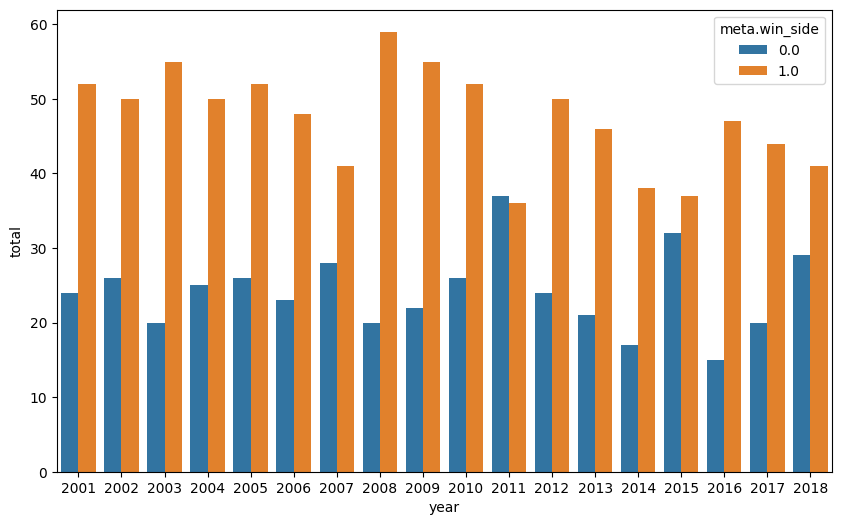

In [91]:
# how many convos and winner per year
aggregate_df = df_convos.groupby(['year', 'meta.win_side']).size().reset_index(name='total')

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='total', hue='meta.win_side', data=aggregate_df)

In [92]:
# Extract Advocate based on Role
import ast
def extract_advocate_names(row, side):
    advocates_dict = ast.literal_eval(row['meta.advocates'])
    names = []
    for advocate, info in advocates_dict.items():
        if info['side'] == side:
            names.append(advocate)
    return ', '.join(names)

df_convos['respondents'] = df_convos.apply(lambda row: extract_advocate_names(row, 0), axis=1)
df_convos['petitioner'] = df_convos.apply(lambda row: extract_advocate_names(row, 1), axis=1)
df_convos['amicus_curiae'] = df_convos.apply(lambda row: extract_advocate_names(row, 2), axis=1)

In [93]:
# Top 10 
advocate_wins = df_convos[df_convos['meta.win_side'] == 1].groupby('petitioner')['petitioner'].count().reset_index(name='win_count')
advocate_total_cases = df_convos.groupby('petitioner')['petitioner'].count().reset_index(name='total_cases')
advocate_stats = pd.merge(advocate_wins, advocate_total_cases, on='petitioner', how='outer')
advocate_stats['win_count'] = advocate_stats['win_count'].fillna(0)
advocate_stats['win_pct'] = advocate_stats['win_count'] / advocate_stats['total_cases'] * 100
advocate_stats.columns = ['advocate_name', 'win_count', 'total_cases', 'win_pct']
advocate_stats.nlargest(10, 'total_cases')

,advocate_name,win_count,total_cases,win_pct
374,paul_d_clement,22.0,32,68.750000
49,carter_g_phillips,15.0,27,55.555556
209,jeffrey_l_fisher,13.0,26,50.000000
455,seth_p_waxman,18.0,22,81.818182
490,theodore_b_olson,16.0,19,84.210526
126,edwin_s_kneedler,11.0,15,73.333333
492,thomas_c_goldstein,7.0,15,46.666667
164,gregory_g_garre,8.0,14,57.142857
255,kannon_k_shanmugam,7.0,13,53.846154
93,david_c_frederick,10.0,12,83.333333


## Initial questions about judge:
- does any judge prefers to vote 1 or 0
- does any judge who votes 1 has high percentage leads to win side
- does judges have same perefernce ( like if he/she votes one, there is a high percentage that the other one would vote 1 too) or speakers

(trying to transfer them into apply + function, but haven't success)

In [94]:
import json

dfconc = df_convos.copy()
dfconc = dfconc.loc[~(dfconc.loc[:,'meta.win_side'].isna()) &
                    ~(dfconc.loc[:,'meta.votes_side'].isna()), ]
dfconc.reset_index(inplace=True)
dfconc.loc[:, 'meta.votes_side'] = dfconc.loc[:, 'meta.votes_side'].apply(lambda x: json.loads(x.replace("'", "\"")))

How many yes(1) votes and percentage for each judge

In [95]:
judges_dic1 = {}

for judges in dfconc.loc[:, 'meta.votes_side']:
    
    for judge, vote in judges.items():
        if judge not in judges_dic1:
            judges_dic1[judge] = 0
        judges_dic1[judge] += vote

In [96]:
judges_dic2 = {}
for judges in dfconc.loc[:, 'meta.votes_side']:
    
    for judge, vote in judges.items():
        if judge not in judges_dic2:
            judges_dic2[judge] = 0
        judges_dic2[judge] += 1

In [97]:
dfj_info = pd.DataFrame({'judges': judges_dic1.keys(),
                              'yes_ct': judges_dic1.values(),
                              'total_ct':judges_dic2.values()})
dfj_info.loc[:, 'yes_rate'] = dfj_info.loc[:, 'yes_ct'] / dfj_info.loc[:, 'total_ct']

Does any judge who votes 1 has high percentage leads to win side

In [98]:
judges_dic3 = {}
for i in range(len(dfconc)):

    for judge, vote in dfconc.loc[:, 'meta.votes_side'][i].items():

        if judge not in judges_dic3:
            judges_dic3[judge] = 0
        if (vote == 1) and (dfconc.loc[:, 'meta.win_side'][i] == 1.0):
            judges_dic3[judge] += 1

In [99]:
dfj_info.loc[:, 'win_ct'] = judges_dic3.values()
dfj_info.loc[:, 'yes_win_rate'] = dfj_info.loc[:, 'win_ct'] / dfj_info.loc[:, 'yes_ct']
dfj_info.loc[:, 'total_win_rate'] = dfj_info.loc[:, 'win_ct'] / dfj_info.loc[:, 'total_ct']

Who has the same agreement

In [100]:
judge_dic4 = {}

for judge in dfj_info['judges']:
    judge_dic4[judge] = {}
    for i in range(len(dfconc)):
        for judge2, vote in dfconc.loc[:, 'meta.votes_side'][i].items():
            if judge2 != judge and judge in dfconc.loc[:, 'meta.votes_side'][i]:
                if judge2 not in judge_dic4[judge]:
                    judge_dic4[judge][judge2] = {}
                    judge_dic4[judge][judge2]['1_1'] = 0
                    judge_dic4[judge][judge2]['1_0'] = 0
                    judge_dic4[judge][judge2]['0_1'] = 0
                    judge_dic4[judge][judge2]['0_0'] = 0
                    judge_dic4[judge][judge2]['total'] = 0
                    
                judge_dic4[judge][judge2]['total'] += 1
                    
                if dfconc.loc[:, 'meta.votes_side'][i][judge] == 1:
                    if vote == 1:
                        judge_dic4[judge][judge2]['1_1'] += 1
                    else:
                        judge_dic4[judge][judge2]['1_0'] += 1
                else:
                    if vote == 1:
                        judge_dic4[judge][judge2]['0_1'] += 1
                    else:
                        judge_dic4[judge][judge2]['0_0'] += 1

In [101]:
judge_dic5 = {}
for judge, peers in judge_dic4.items():
    judge_dic5[judge] = []
    for peer, vote in peers.items():

        if vote['1_1'] / vote['total'] > 0.55: # set a threshold
            judge_dic5[judge].append(peer)

In [102]:
dfj_info.loc[:, 'friends'] = judge_dic5.values()
dfj_info.loc[:, 'j_short'] = dfj_info.loc[:, 'judges'].str[3:7]

In [103]:
dfj_info

,judges,yes_ct,total_ct,yes_rate,win_ct,yes_win_rate,total_win_rate,friends,j_short
0,j__william_h_rehnquist,198,291,0.680412,174,0.878788,0.597938,"[j__sandra_day_oconnor, j__antonin_scalia, j__...",will
1,j__john_paul_stevens,384,674,0.569733,327,0.851562,0.485163,[],john
2,j__sandra_day_oconnor,225,316,0.712025,205,0.911111,0.648734,"[j__william_h_rehnquist, j__anthony_m_kennedy,...",sand
3,j__antonin_scalia,648,1035,0.626087,568,0.876543,0.548792,"[j__william_h_rehnquist, j__clarence_thomas, j...",anto
4,j__anthony_m_kennedy,802,1216,0.659539,753,0.938903,0.619243,"[j__william_h_rehnquist, j__sandra_day_oconnor...",anth
5,j__david_h_souter,359,596,0.602349,315,0.877437,0.528523,[j__stephen_g_breyer],davi
6,j__clarence_thomas,746,1285,0.580545,661,0.886059,0.514397,"[j__william_h_rehnquist, j__antonin_scalia]",clar
7,j__ruth_bader_ginsburg,732,1288,0.568323,653,0.892077,0.506988,[],ruth
8,j__stephen_g_breyer,779,1275,0.610980,688,0.883184,0.539608,"[j__sandra_day_oconnor, j__david_h_souter]",step
9,j__john_g_roberts_jr,625,975,0.641026,580,0.928000,0.594872,"[j__antonin_scalia, j__anthony_m_kennedy, j__s...",john


<Axes: xlabel='j_short', ylabel='yes_win_rate'>

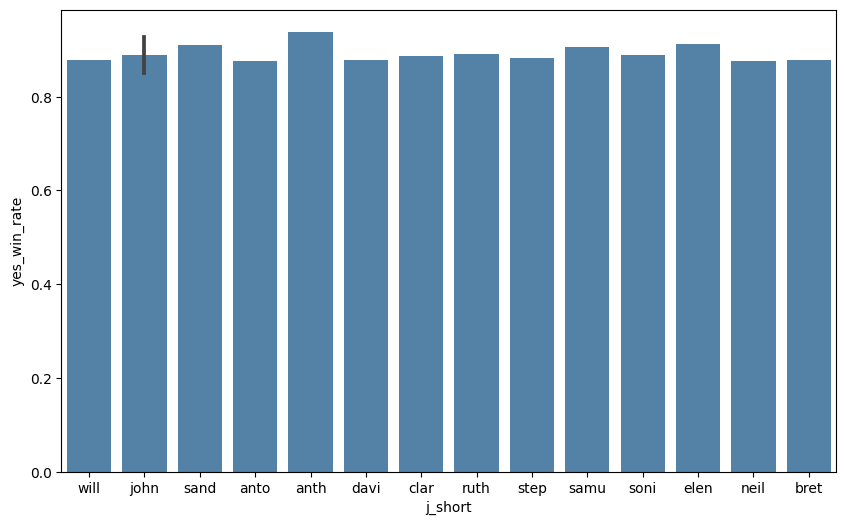

In [104]:
plt.figure(figsize=(10, 6))
sns.barplot(x='j_short', y='yes_win_rate',color = 'steelblue', data = dfj_info)

<Axes: xlabel='j_short', ylabel='total_win_rate'>

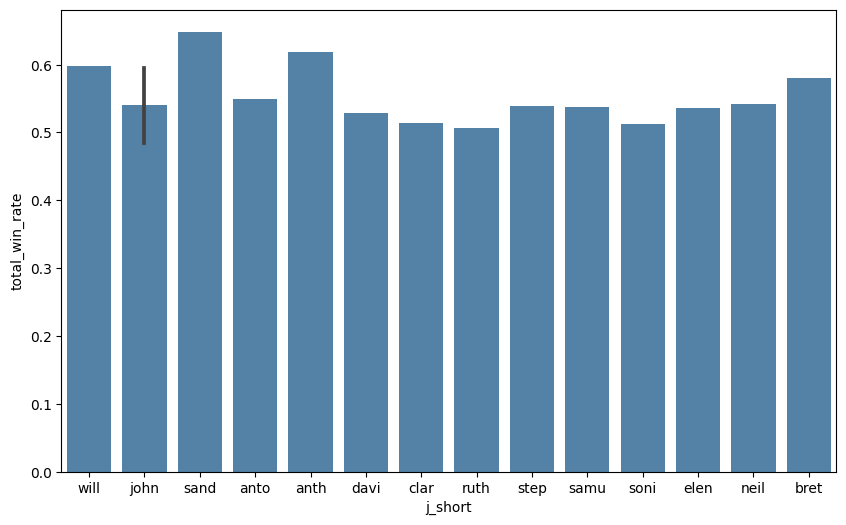

In [105]:
plt.figure(figsize=(10, 6))
sns.barplot(x='j_short', y='total_win_rate',color = 'steelblue', data = dfj_info)

## Test Prediction without Further Preprocess and not setting hyperparameter

In [106]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [107]:
# combine text from all utterances in a conversation back into one string based on the conversation_id
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_merge = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

df_convos_merge.head(1)

,id,vectors,meta.case_id,meta.advocates,meta.win_side,meta.votes_side,year,respondents,petitioner,amicus_curiae,conversation_id,text
0,22149,[],2001_01-584,"{'john_crabtree': {'side': 1, 'role': 'on beha...",0.0,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",2001,glen_d_nager,john_crabtree,"alfred_w_blumrosen, ruth_g_blumrosen, archibal...",22149,"We'll hear argument now on number 01-584, Wand..."


In [108]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [109]:
text = df_convos_merge.loc[:,['text','meta.win_side']]
text['text'] = text['text'].apply(preprocess_text) #apply preprocess
text.head(1)

,text,meta.win_side
0,hear argument number wanda adams vs florida po...,0.0


In [110]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(2, 2)) # check bigram
X = vectorizer.fit_transform(text['text'])

y = text['meta.win_side']

In [111]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

logistic_regression = LogisticRegression()
naive_bayes = MultinomialNB()
linear_svc = LinearSVC()


# Train and evaluate the classifiers
classifiers = {
    "Logistic Regression": logistic_regression,
    "Naive Bayes": naive_bayes,
    "Linear SVC": linear_svc
}

results = []

for classifier_name, classifier in classifiers.items():

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Add the scores to the results dictionary
    results.append({
        'classifier': classifier,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    })

In [113]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
results_df

,classifier,accuracy,f1,precision,recall
0,LogisticRegression(),0.651163,0.788732,0.651163,1.000000
1,MultinomialNB(),0.651163,0.788732,0.651163,1.000000
2,LinearSVC(),0.635659,0.775120,0.648000,0.964286


##Questions about gender?
- What was the gender breakdown of the advocates?
- What was the most common first name of the speakers?
- Does the gender of the advocates influence whether they win or not?

So I downloaded a dataset from the Uni of Cali, Irvine that predicts the gender of the speaker based off their first name. Link: https://archive.ics.uci.edu/ml/datasets/Gender+by+Name

In [114]:
df_gender = pd.read_csv(r'https://raw.githubusercontent.com/rezarzky/supreme-prediction/main/dataset/name_gender_dataset.csv')
idx = df_gender.groupby(['Name'])['Probability'].idxmax()
df_gender = df_gender.loc[idx]

In [115]:
speaker_gender_df = df_speakers.copy()
speaker_gender_df.loc[:, ['first_name']] = speaker_gender_df.loc[:, 'meta.name'].str.split(' ').str[0]
speaker_gender_df = pd.merge(speaker_gender_df, df_gender, how='inner', left_on = 'first_name', right_on = 'Name')
speaker_gender_df["Gender"].value_counts()

M    1921
F     452
Name: Gender, dtype: int64

In [116]:
speaker_gender_df["Gender"].value_counts(normalize=True)

M    0.809524
F    0.190476
Name: Gender, dtype: float64

In [117]:
speaker_gender_df.groupby(['meta.type'])['Gender'].value_counts()

meta.type  Gender
A          M         1808
           F          407
J          M          113
           F           45
Name: Gender, dtype: int64

In [118]:
speaker_gender_df["first_name"].value_counts(normalize=True).loc[lambda x : x>.02]

David      0.039612
John       0.038769
Michael    0.031606
Paul       0.028234
Thomas     0.026970
Jeffrey    0.023599
Stephen    0.023177
Robert     0.022335
James      0.021492
Name: first_name, dtype: float64

In [119]:
df_convos_gender = df_convos.copy()
test_tup = [tuple(r) for r in df_convos_gender.loc[:, ['meta.case_id', \
                                'meta.advocates', 'meta.win_side']].to_numpy()]
lst_case_person = []

for case_id, person_deets, win_side in test_tup:
    person_deets = eval(person_deets)
    for person, details in person_deets.items():
        lst_case_person.append((case_id, person, win_side))
   

person_case_df = pd.DataFrame(lst_case_person, columns=['meta.case_id', 'id', 'win_side'])

In [120]:
#cleaning
#going to remove 27 rows w/empty value in id column
person_case_df = person_case_df.loc[(person_case_df.loc[:,'id'] != ''), :]

In [121]:
small_speakergenderdf = speaker_gender_df.loc[:, ['id', 'meta.name',\
                                              'meta.type', 'Gender']]


person_case_gender_df = pd.merge(person_case_df, small_speakergenderdf, how='inner', left_on = 'id', right_on = 'id')
person_case_gender_df = person_case_gender_df.drop_duplicates()
person_case_gender_df.head(5)

,meta.case_id,id,win_side,meta.name,meta.type,Gender
0,2001_01-584,john_crabtree,0.0,John Crabtree,A,M
1,2001_01-584,glen_d_nager,0.0,Glen D. Nager,A,M
7,2001_00-1045,glen_d_nager,1.0,Glen D. Nager,A,M
13,2002_01-1269,glen_d_nager,1.0,Glen D. Nager,A,M
19,2004_03-1160,glen_d_nager,0.0,Glen D. Nager,A,M


In [122]:
result = sm.ols(formula = "win_side ~ Gender", data = person_case_gender_df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               win_side   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9162
Date:                Sat, 22 Apr 2023   Prob (F-statistic):              0.339
Time:                        03:33:01   Log-Likelihood:                -2192.5
No. Observations:                3256   AIC:                             4389.
Df Residuals:                    3254   BIC:                             4401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6749      0.020     33.832      

Gender is not expected to affect the outcome of case (1,0 ~ winning or not winning side).


## Who are our Justices?

- Who are our justices? <br>
- What percentage of the justices were installed during Republican v Democratic administrations?<br>
- How do justices' votes correlate with each other's and with the average votes of their fellow political party's appointees?<br>
-What are our bigrams for the first year of each administration versus the last year?

In [123]:
df_speakers.loc[(df_speakers.loc[:, 'meta.role'] == 'justice') & (df_speakers['year'].isin(range(2001,2019))), ['meta.name']].drop_duplicates('meta.name')

,meta.name
0,William H. Rehnquist
2,Antonin Scalia
3,Anthony M. Kennedy
4,John Paul Stevens
5,Ruth Bader Ginsburg
6,Stephen G. Breyer
7,Sandra Day O'Connor
8,David H. Souter
55,Clarence Thomas
71,"John G. Roberts, Jr."


In [124]:
df_polj = pd.read_csv(r'https://raw.githubusercontent.com/rezarzky/supreme-prediction/main/dataset/Justices_Political.csv')

In [125]:
composition = df_polj['Administration Appointed'].value_counts(normalize=True) * 100
print(f"Percentage of Justices based on Administrations they were appointed under {composition}")

Percentage of Justices based on Administrations they were appointed under R    76.470588
D    23.529412
Name: Administration Appointed, dtype: float64


Which justices served on the most cases in our dataset (i.e how many times did they vote?)

In [126]:
import ast

df_convos['meta.votes_side'] = df_convos['meta.votes_side'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_convos['justice_names'] = df_convos['meta.votes_side'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else [])
df_exploded = df_convos.explode('justice_names')
name_counts = df_exploded['justice_names'].value_counts()

In [127]:
print(f"How many times each Justice appears in our subset {name_counts}")

How many times each Justice appears in our subset j__ruth_bader_ginsburg    1288
j__clarence_thomas        1285
j__stephen_g_breyer       1275
j__anthony_m_kennedy      1216
j__antonin_scalia         1035
j__john_g_roberts_jr       975
j__samuel_a_alito_jr       941
j__sonia_sotomayor         678
j__john_paul_stevens       674
j__david_h_souter          596
j__elena_kagan             571
j__sandra_day_oconnor      316
j__william_h_rehnquist     291
j__neil_gorsuch            144
j__brett_m_kavanaugh        62
Name: justice_names, dtype: int64


<h3> Understanding Correlations </h3>
We are trying to understand correlations between how justices appointed during Republican administrations and those appointed during Democratic administrations vote. Additionally, we are analyzing correlations in voting patterns between each individual justice versus others. 

In [128]:
import ast

rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',\
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']

df_convos['meta.votes_side'] = df_convos['meta.votes_side'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_convos['party'] = df_convos['meta.votes_side'].apply(lambda x: 'Republican' if isinstance(x, dict) and any(name in x for name in rep_judge) else ('Democratic' if isinstance(x, dict) and any(name in x for name in dem_judge) else None))
for name in rep_judge + dem_judge:
    df_convos[name] = df_convos['meta.votes_side'].apply(lambda x: x.get(name) if isinstance(x, dict) else None)

df_convos['avg_rep_vote'] = df_convos[rep_judge].mean(axis=1)
df_convos['avg_dem_vote'] = df_convos[dem_judge].mean(axis=1)

corr = df_convos[['party'] + rep_judge + dem_judge + ['avg_rep_vote', 'avg_dem_vote']].corr(numeric_only=True)

In [129]:
print(f"Here is our correlation matrix {corr}")
#Note: the NaN represents Justices who were not likely to have served at the Court during the same time periods. E.g David H Souter and Neil Gorsuch.

Here is our correlation matrix                         j__clarence_thomas  j__anthony_m_kennedy  \
j__clarence_thomas                1.000000              0.553479   
j__anthony_m_kennedy              0.553479              1.000000   
j__antonin_scalia                 0.784898              0.564426   
j__john_g_roberts_jr              0.668051              0.697952   
j__samuel_a_alito_jr              0.727476              0.669186   
j__john_paul_stevens              0.063300              0.290381   
j__david_h_souter                 0.141161              0.355850   
j__william_h_rehnquist            0.652448              0.722813   
j__neil_gorsuch                   0.663678              0.722555   
j__brett_m_kavanaugh              0.592766                   NaN   
j__ruth_bader_ginsburg            0.183185              0.432897   
j__stephen_g_breyer               0.199934              0.488800   
j__sonia_sotomayor                0.236567              0.509679   
j__elena_kagan   

In [130]:
print(df_utts.head())

             id  timestamp                                               text  \
0  22149__0_000        NaN  We'll hear argument now on number 01-584, Wand...   
1  22149__0_001        NaN  Mr. Chief Justice, may it please the Court: Th...   
2  22149__0_002        NaN  Mr. Crabtree, we are not talking about a situa...   
3  22149__0_003        NaN  No, Your Honor.\nWe believe that disparate imp...   
4  22149__0_004        NaN  Well, now in Washington against Davis, we held...   

                  speaker      reply_to  conversation_id meta.case_id  \
0  j__william_h_rehnquist           NaN            22149  2001_01-584   
1           john_crabtree  22149__0_000            22149  2001_01-584   
2  j__william_h_rehnquist  22149__0_001            22149  2001_01-584   
3           john_crabtree  22149__0_002            22149  2001_01-584   
4  j__william_h_rehnquist  22149__0_003            22149  2001_01-584   

   meta.start_times   meta.stop_times meta.speaker_type  meta.side  \
0   

For the first year of the Bush administration (2001) and the first year of the Obama administration (2008), what are our bigrams? 

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

mask = (df_utts['year'] == 2001) | (df_utts['year'] == 2009)
df_filtered = df_utts[mask]
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words = 'english')
X = vectorizer.fit_transform(df_filtered['text'])
bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bigram_counts = bigrams.sum()
most_common_bigrams = bigram_counts.nlargest(n=3)

print(most_common_bigrams)


chief justice     845
don think         773
district court    755
dtype: int64


In [132]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

mask = (df_utts['year'] == 2008) | (df_utts['year'] == 2016)
df_filtered = df_utts[mask]
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words = 'english')
X = vectorizer.fit_transform(df_filtered['text'])
bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bigram_counts = bigrams.sum()
most_common_bigrams_2 = bigram_counts.nlargest(n=3)

print(most_common_bigrams_2)


don think         1033
district court     922
chief justice      906
dtype: int64
